# Example for the homework

In [ ]:
!git clone https://github.com/DeepStudio-TW/small-data-ssl-lecture.git
%cd small-data-ssl-lecture

In [ ]:
# 升級 gdown 套件
!pip install -q --upgrade gdown
# Download dataset
!gdown -q  https://drive.google.com/uc?id=1UAeZqIDqYm4pwQEkr1iTaVuq4tOgLL2O
# Unzip the files
!tar zxf  kaggle.tar.gz

In [5]:
# 讀取基本套件
import shutil, os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
# Backend: pytorch
import torch


In [6]:
# 設一個 show data和label的function
def show_data(imgs, titles,cmap=None):
    # imshow, 縮放模式為nearest。
    plt.figure(figsize=(18, 18))
    for id,(img,title) in enumerate(zip(imgs,titles)):
        plt.subplot(1, len(titles), id+1)
        fig = plt.imshow(img,interpolation='nearest',cmap=cmap)
        plt.axis("off")
        plt.title(title)

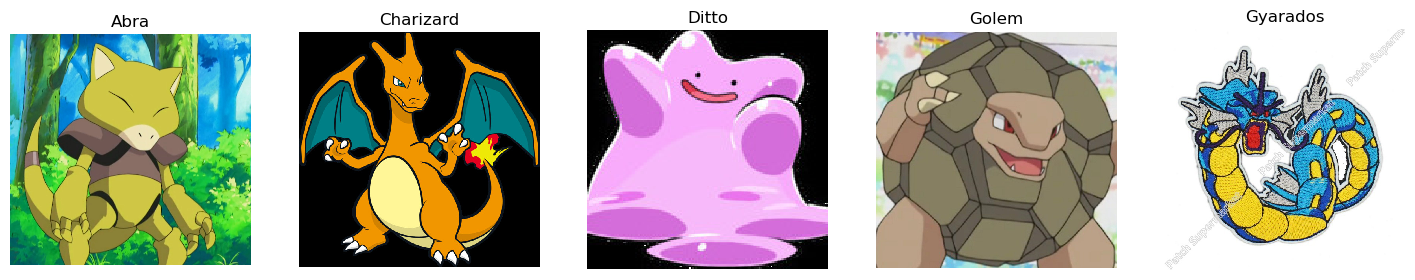

In [7]:
# 看source data: 
titles = ['Abra', 'Charizard', 'Ditto', 'Golem', 'Gyarados']
example_files=[glob(f"source/{i}/*.jpg")[0] for i in titles]
show_data([*map(plt.imread,example_files)],titles)

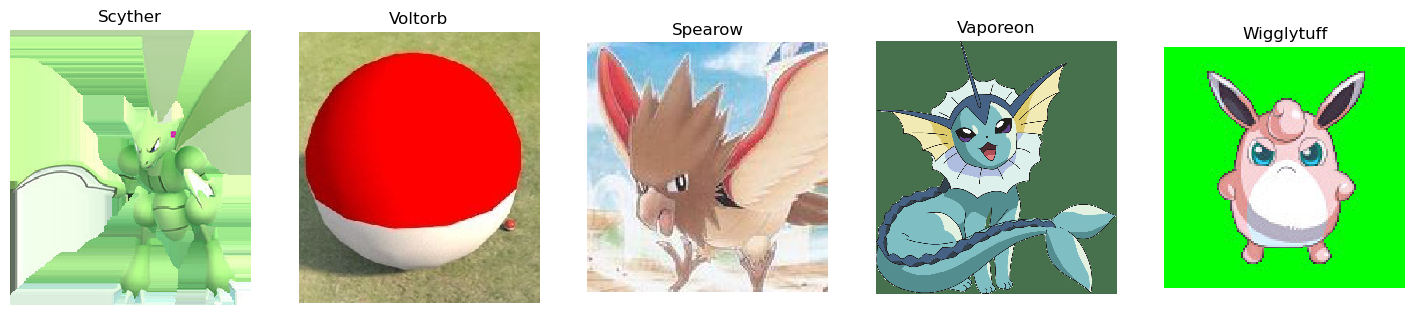

In [8]:
# 看target data
titles = ['Scyther', 'Voltorb', 'Spearow', 'Vaporeon', 'Wigglytuff']
example_files=[glob(f"target_support/{i}/*.jpg")[0] for i in titles]
show_data([*map(plt.imread,example_files)],titles)

In [9]:
np.random.seed(5566)
# 自己將source dataset依照class切成兩半，供自己驗證
all_classes = glob('source/*')
C=80
src_cls=np.random.permutation(all_classes)
src_cls,val_cls=src_cls[:C],src_cls[C:]

In [10]:
# ## 將抽選的source classes資料移到source1這個資料夾
# for c in src_cls:
#     c_name=os.path.basename(c)
#     os.makedirs('source1',exist_ok=True)
#     os.system(f"cp -rLf {c} source1/{c_name}")
# ## 將抽選的validation class資料移到val_support這個資料夾
# for c in val_cls:
#     c_name=os.path.basename(c)
#     os.makedirs('val_support',exist_ok=True)
#     os.system(f"cp -rLf {c} val_support/{c_name}")
    
# ## 將val_support裡面資料又切成support跟query兩部分
# np.random.seed(5566)
# val_classes = glob('val_support/*')
# for class_dir in val_classes:
#     label_name=os.path.basename(class_dir)
#     # copy some pics to new dir
#     label_pics=glob(os.path.join(class_dir,"*.jpg"))
#     label_pics=np.random.choice(label_pics,size=15,replace=False)
#     class_dir=os.path.join("val_query",label_name)
#     os.makedirs(class_dir,exist_ok = True)
#     for f in label_pics:
#         shutil.move(src=f, dst=class_dir)

In [11]:
import torchvision.transforms as tvt
import torchvision.datasets as tvds

train_transform = tvt.Compose([
    tvt.RandomHorizontalFlip(),
    # 旋轉15度內 (Augmentation)，旋轉後空的地方補0
    tvt.RandomRotation(15, fill=(0,0,0)),
    # 最後轉成Tensor供model使用。
    tvt.ToTensor(),
    tvt.Resize((128,128))
])
test_transform = tvt.Compose([
    tvt.ToTensor(),
    tvt.Resize((128,128))
])

# 原本Source套用source的transform
source_dataset = tvds.ImageFolder('source', transform=train_transform)
# 切出的Source套用source的transform
source_dataset1 = tvds.ImageFolder('source1', transform=train_transform)

# 切出的Val套用target的transform
val_support_dataset = tvds.ImageFolder('val_support', transform=train_transform)
val_query_dataset = tvds.ImageFolder('val_query', transform=test_transform)


# Target套用target的transform
target_support_dataset = tvds.ImageFolder('target_support', transform=test_transform)

In [12]:
from torch.utils import data as tud
from supp.fsl_dataset import FewShotSampler

In [13]:
len(val_support_dataset.classes)

58

In [14]:
# source跟target都使用小batch size
BS_TRAIN=32
BS_TEST=128
source_dataloader=tud.DataLoader(source_dataset, 
                    batch_size=BS_TRAIN,
                    shuffle=True,
                    num_workers=2,
                    pin_memory=False)

source_dataloader1=tud.DataLoader(source_dataset1, 
                    batch_size=BS_TRAIN,
                    shuffle=True,
                    num_workers=2,
                    pin_memory=False)



sampler=FewShotSampler(val_support_dataset,val_support_dataset.classes,shots=5,repeats=3)
val_support_dataloader=tud.DataLoader(val_support_dataset, 
                    batch_size=BS_TRAIN,
                    shuffle=False,
                    num_workers=2,
                    pin_memory=False,
                    sampler=sampler)

val_query_dataloader=tud.DataLoader(val_query_dataset, 
                    batch_size=BS_TEST,
                    shuffle=False,
                    num_workers=2,
                    pin_memory=False)

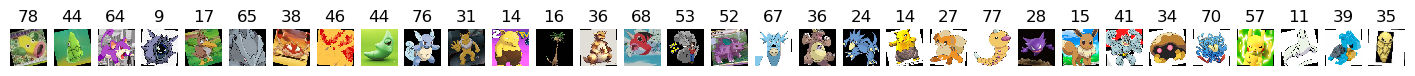

In [16]:
for x,y in source_dataloader1:
    break
show_data(x.numpy().transpose(0,2,3,1),y.numpy())

In [17]:
WAYS=len(source_dataset.classes)
SHOTS=5

In [19]:
from torch import nn
from supp.nn_model import (FeatureExtractor,Baseline,MetricLayer,cosine)
#@title Model Selection
#@markdown Latent space dimension
latent_dims=32 #@param
backbone=FeatureExtractor(latent_features=latent_dims,hidden_featrues=(64,128,128))

#@markdown Model (transfer learning): export model=ModelClass(*args)
model_type="baseline" #@param ["baseline","baseline++"]
if model_type=="baseline":
    head=nn.Linear(latent_dims,WAYS)
elif model_type=="baseline++":
    head=MetricLayer(latent_dims,WAYS,cosine)   
else:
    print("unrecognizable head")
    
model=Baseline(WAYS,backbone,head,dropout=True).cuda()

In [20]:
from torch import nn
from supp.nn_model import (FocalLoss,AddMarginLoss,ArcMarginLoss)
#@title Loss (transfer learning)
#@markdown  export criterion=LossClass(*args)
loss_type="addmargin" #@param ["cce","focal","addmargin","arcmargin"]
if loss_type=="cce":
    criterion = nn.CrossEntropyLoss()
elif loss_type=="focal":
    criterion = FocalLoss(gamma=9)
elif loss_type=="addmargin":
    criterion = AddMarginLoss(s=15.0, m=0.40,ways=WAYS,loss_fn=FocalLoss())
elif loss_type=="arcmargin":
    criterion = ArcMarginLoss(s=32.0, m=0.40,ways=WAYS, easy_margin=False,loss_fn=FocalLoss())
else:
    print("unrecognizable loss")



In [21]:
import torch.optim as optim
lr=1e-3
optimizer=optim.Adam(model.parameters(),lr=lr)

In [22]:
EPOCHS=60
# For scheduler
# scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [23]:
from tqdm.notebook import tqdm
def train_epoch(epoch,model,criterion,optimizer,dataloader,adapt=False):
    running_loss = 0.0 # Feature Extrator & Label Predictor的loss
    total_hit, total_num = 0.0, 0.0 # total_hit: 計算目前對了幾筆 total_num: 目前經過了幾筆
    session=tqdm(enumerate(dataloader))
    for i, (data, label) in session:
        data = data.cuda()
        label = label.cuda()

        # 訓練整個model
        if not adapt:
            class_logits = model(data)
        # Adaptation時不訓練backbone
        else:
            with torch.no_grad():
                latent = model.backbone(data)
            # 不訓練backbone
            class_logits=model.head(latent.detach())
        # loss以指定的為主
        loss = criterion(class_logits, label)
        loss.backward()
        
        optimizer.step()
        # scheduler.step(loss) # For scheduler
        optimizer.zero_grad()

        running_loss+= loss.item()
        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == label).item()
        total_num += data.shape[0]

        session.set_postfix({"epoch":epoch,"loss":loss.item(),"acc":total_hit / total_num})
    return running_loss / (i+1), total_hit / total_num

In [24]:
def run_test(model,data_loader):
    result = dict(y_true=[],y_pred=[])
    total_test_hit, total_test_num = 0.0, 0.0
    with torch.no_grad():
        for i, (data,label) in enumerate(data_loader):
            
            test_data = data.cuda()
            test_label = label.cuda()

            class_logits = model(test_data)

            pred = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
            result['y_true'].extend(label.cpu().detach().numpy())
            result['y_pred'].extend(pred)
            
            
            total_test_hit += torch.sum(torch.argmax(class_logits, dim=1) == test_label).item()
            total_test_num += test_data.shape[0]

    print("test acc:",total_test_hit / total_test_num)
    return result,total_test_hit / total_test_num

In [25]:
# 訓練 Source
try:
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(epoch,model,criterion,optimizer,source_dataloader1,adapt=False)
        torch.save(model.state_dict(), f'{model_type}_{loss_type}.bin')
except KeyboardInterrupt:
    print("KeyboardInterrupt")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [26]:
WAYS2=len(val_support_dataset.classes)

In [27]:
#@title Target Model Head
#@markdown Model (transfer learning): export model_tgt=ModelClass(old_backbone,new_head)
model_type="baseline++" #@param ["baseline","baseline++"]
if model_type=="baseline":
    head_tgt=nn.Linear(latent_dims,WAYS2)
elif model_type=="baseline++":
    head_tgt=MetricLayer(latent_dims,WAYS2,cosine)
else:
    print("unrecognizable head")
model_tgt=Baseline(WAYS2,backbone,head_tgt,dropout=True).cuda()
#@markdown Loss (transfer learning): export criterion=LossClass(*args)
loss_type="arcmargin" #@param ["cce","focal","addmargin","arcmargin"]
if loss_type=="cce":
    criterion_tgt = nn.CrossEntropyLoss()
elif loss_type=="focal":
    criterion_tgt = FocalLoss(gamma=2)
elif loss_type=="addmargin":
    criterion_tgt = AddMarginLoss(s=15.0, m=0.40,ways=WAYS2,loss_fn=FocalLoss())
elif loss_type=="arcmargin":
    criterion_tgt = ArcMarginLoss(s=32.0, m=0.40,ways=WAYS2, easy_margin=False,loss_fn=FocalLoss())
else:
    print("unrecognizable loss")

optimizer_tgt=optim.Adam(model_tgt.parameters(),lr=lr*10)

In [28]:
# 訓練 target
try:
    EPOCHS2=5
    
    for epoch in range(EPOCHS2):
        model_tgt.train()
        model_tgt.backbone.eval()
        train_loss, train_acc = train_epoch(epoch,model_tgt,criterion_tgt,optimizer_tgt,val_support_dataloader,adapt=True)
        torch.save(model.state_dict(), f'{model_type}_{loss_type}_adapted.bin')
        
        model_tgt.eval()
        pred,acc=run_test(model_tgt,val_query_dataloader)
except KeyboardInterrupt:
    print("KeyboardInterrupt")

0it [00:00, ?it/s]

test acc: 0.06206896551724138


0it [00:00, ?it/s]

test acc: 0.16896551724137931


0it [00:00, ?it/s]

test acc: 0.2057471264367816


0it [00:00, ?it/s]

test acc: 0.25057471264367814


0it [00:00, ?it/s]

test acc: 0.2689655172413793


In [27]:
from sklearn.metrics import confusion_matrix,classification_report

              precision    recall  f1-score   support

           0       0.43      0.40      0.41        15
           1       0.17      0.07      0.10        15
           2       0.19      0.40      0.26        15
           3       0.53      0.60      0.56        15
           4       0.14      0.20      0.16        15
           5       0.69      0.60      0.64        15
           6       0.33      0.13      0.19        15
           7       0.37      0.47      0.41        15
           8       0.46      0.40      0.43        15
           9       0.56      0.33      0.42        15
          10       0.50      0.20      0.29        15
          11       0.31      0.33      0.32        15
          12       0.11      0.07      0.08        15
          13       0.61      0.73      0.67        15
          14       0.50      0.07      0.12        15
          15       0.12      0.07      0.09        15
          16       0.35      0.47      0.40        15
          17       0.26    

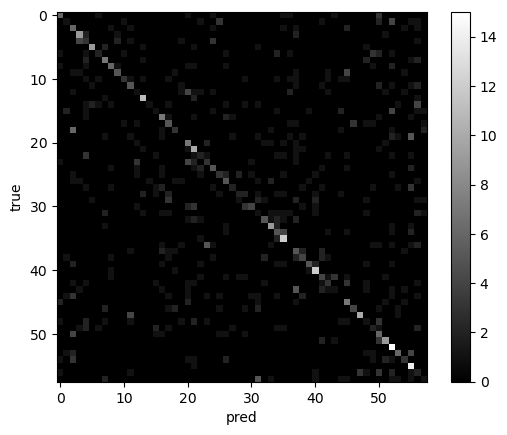

In [28]:
print(classification_report(pred['y_true'], pred['y_pred']))
plt.imshow(confusion_matrix(pred['y_true'], pred['y_pred']),'gray')
plt.colorbar()
plt.ylabel("true")
plt.xlabel("pred");plt.show()

## pre-train on full dataset

In [29]:
WAYS3=len(source_dataset.classes)

In [96]:
from torch import nn
from supp.nn_model import (FeatureExtractor,Baseline,MetricLayer,cosine)
from supp.nn_model import (FocalLoss,AddMarginLoss,ArcMarginLoss)

#@title Model Selection
#@markdown Latent space dimension
latent_dims=32 #@param
backbone=FeatureExtractor(latent_features=latent_dims,hidden_featrues=(64,128,128))

#@markdown Model (transfer learning): export model=ModelClass(*args)
model_type="baseline++" #@param ["baseline","baseline++"]
if model_type=="baseline":
    head=nn.Linear(latent_dims,WAYS)
elif model_type=="baseline++":
    head=MetricLayer(latent_dims,WAYS,cosine)   
else:
    print("unrecognizable head")
    
model=Baseline(WAYS,backbone,head,dropout=True).cuda()
#@title Loss (transfer learning)
#@markdown  export criterion=LossClass(*args)
loss_type="addmargin" #@param ["cce","focal","addmargin","arcmargin"]
if loss_type=="cce":
    criterion = nn.CrossEntropyLoss()
elif loss_type=="focal":
    criterion = FocalLoss(gamma=9)
elif loss_type=="addmargin":
    criterion = AddMarginLoss(s=15.0, m=0.40,ways=WAYS,loss_fn=FocalLoss())
elif loss_type=="arcmargin":
    criterion = ArcMarginLoss(s=32.0, m=0.40,ways=WAYS, easy_margin=False,loss_fn=FocalLoss())
else:
    print("unrecognizable loss")

In [97]:
import torch.optim as optim
lr=1e-2
optimizer=optim.Adam(model.parameters(),lr=lr)

In [99]:
# 訓練 target
try:
    EPOCHS2=60
    for epoch in range(EPOCHS2):
        model.train()
        train_loss, train_acc = train_epoch(epoch,model,criterion,optimizer,source_dataloader,adapt=False)
        torch.save(model.state_dict(), f'{model_type}_{loss_type}.bin')
except KeyboardInterrupt:
    print("KeyboardInterrupt")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

# Adapt to target support

In [100]:
WAYS4=len(['Scyther', 'Voltorb', 'Spearow', 'Vaporeon', 'Wigglytuff'])

In [101]:
#@title Target Model Head
#@markdown Model (transfer learning): export model_tgt=ModelClass(old_backbone,new_head)
model_type="baseline++" #@param ["baseline","baseline++"]
if model_type=="baseline":
    head_tgt=nn.Linear(latent_dims,WAYS4)
elif model_type=="baseline++":
    head_tgt=MetricLayer(latent_dims,WAYS4,cosine)
else:
    print("unrecognizable head")
model_tgt=Baseline(WAYS3,backbone,head_tgt,dropout=True).cuda()
#@markdown Loss (transfer learning): export criterion=LossClass(*args)
loss_type="arcmargin" #@param ["cce","focal","addmargin","arcmargin"]
if loss_type=="cce":
    criterion_tgt = nn.CrossEntropyLoss()
elif loss_type=="focal":
    criterion_tgt = FocalLoss(gamma=2)
elif loss_type=="addmargin":
    criterion_tgt = AddMarginLoss(s=15.0, m=0.40,ways=WAYS4,loss_fn=FocalLoss())
elif loss_type=="arcmargin":
    criterion_tgt = ArcMarginLoss(s=32.0, m=0.40,ways=WAYS4, easy_margin=False,loss_fn=FocalLoss())
else:
    print("unrecognizable loss")

optimizer_tgt=optim.Adam(model_tgt.parameters(),lr=lr*10)

In [102]:
sampler2=FewShotSampler(target_support_dataset,['Scyther', 'Voltorb', 'Spearow', 'Vaporeon', 'Wigglytuff'],shots=5,repeats=5)
target_support_dataloader=tud.DataLoader(target_support_dataset, 
                    batch_size=BS_TRAIN,
                    shuffle=False,
                    num_workers=2,
                    pin_memory=False,
                    sampler=sampler2)

In [103]:
# 訓練 target
try:
    EPOCHS2=5
    for epoch in range(EPOCHS2):
        model_tgt.train()
        model_tgt.backbone.train()
        train_loss, train_acc = train_epoch(epoch,model_tgt,criterion_tgt,optimizer_tgt,target_support_dataloader,adapt=True)
        torch.save(model.state_dict(), f'{model_type}_{loss_type}_adapted.bin')
except KeyboardInterrupt:
    print("KeyboardInterrupt")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [104]:
import pandas as pd
test_df=pd.read_csv('SampleSubmission.csv')
filenames=['target_query/'+v for v in test_df.filename.values]

In [105]:
import PIL
outputs=[*map(test_transform,map(PIL.Image.open,np.array(filenames)))]
target_query_dataloader=tud.DataLoader(outputs, 
                    batch_size=BS_TRAIN,
                    shuffle=False,
                    num_workers=2,
                    pin_memory=False)

In [106]:
pred=[]
with torch.no_grad():
    for data in target_query_dataloader:
        test_data = data.cuda()
        class_logits = model_tgt(test_data)
        pred.extend(torch.argmax(class_logits, dim=1).cpu().detach().numpy())
test_df['ans']=pred
test_df.to_csv('baseline.csv',index=False)